In [1]:
import pandas as pd
df = pd.read_csv('SEP-28k_labels.csv')
df.head()

,Show,EpId,ClipId,Start,Stop,Unsure,PoorAudioQuality,Prolongation,Block,SoundRep,WordRep,DifficultToUnderstand,Interjection,NoStutteredWords,NaturalPause,Music,NoSpeech
0,HeStutters,0,0,31900320,31948320,0,0,0,0,0,0,0,0,3,1,0,0
1,HeStutters,0,1,31977120,32025120,0,0,0,0,0,0,0,0,3,1,0,0
2,HeStutters,0,2,34809760,34857760,0,0,0,0,0,0,0,0,3,0,0,0
3,HeStutters,0,3,35200640,35248640,0,0,1,0,0,0,0,0,2,0,0,0
4,HeStutters,0,4,35721920,35769920,0,0,0,0,0,0,0,0,3,0,0,0


In [2]:
df.shape

(28177, 17)

In [3]:
df.columns

Index(['Show', 'EpId', 'ClipId', 'Start', 'Stop', 'Unsure', 'PoorAudioQuality',
       'Prolongation', 'Block', 'SoundRep', 'WordRep', 'DifficultToUnderstand',
       'Interjection', 'NoStutteredWords', 'NaturalPause', 'Music',
       'NoSpeech'],
      dtype='object')

## Adding Name Column

In [4]:
df['Name'] = df[df.columns[0:3]].apply(
    lambda x: '_'.join(x.dropna().astype(str)),
    axis=1
)
df.head()

,Show,EpId,ClipId,Start,Stop,Unsure,PoorAudioQuality,Prolongation,Block,SoundRep,WordRep,DifficultToUnderstand,Interjection,NoStutteredWords,NaturalPause,Music,NoSpeech,Name
0,HeStutters,0,0,31900320,31948320,0,0,0,0,0,0,0,0,3,1,0,0,HeStutters_0_0
1,HeStutters,0,1,31977120,32025120,0,0,0,0,0,0,0,0,3,1,0,0,HeStutters_0_1
2,HeStutters,0,2,34809760,34857760,0,0,0,0,0,0,0,0,3,0,0,0,HeStutters_0_2
3,HeStutters,0,3,35200640,35248640,0,0,1,0,0,0,0,0,2,0,0,0,HeStutters_0_3
4,HeStutters,0,4,35721920,35769920,0,0,0,0,0,0,0,0,3,0,0,0,HeStutters_0_4


In [5]:
df['Name']

0                HeStutters_0_0
1                HeStutters_0_1
2                HeStutters_0_2
3                HeStutters_0_3
4                HeStutters_0_4
                  ...          
28172    WomenWhoStutter_109_35
28173    WomenWhoStutter_109_36
28174    WomenWhoStutter_109_37
28175    WomenWhoStutter_109_38
28176    WomenWhoStutter_109_39
Name: Name, Length: 28177, dtype: object

## Removing Empty Audios and there Dataset Entries

In [6]:
import os
os.stat("clips/stuttering-clips/clips/HeStutters_0_9.wav").st_size

# empty files have st_size of 44

44

In [7]:
os.stat("clips/stuttering-clips/clips/HeStutters_1_1.wav").st_size

# non empty file

96044

## Put empty filenames in a list and ignore them while feature extraction and training

In [8]:
CLIPS_DIR = "clips/stuttering-clips/clips/"
ignore_list = []
for filename in os.listdir(CLIPS_DIR):
    file_path = CLIPS_DIR + filename
    if 'FluencyBank' not in filename:
        if os.stat(file_path).st_size == 44:
            ignore_list.append(filename)
            filename = filename[:-4]
            df = df[df.Name != filename]

print(len(ignore_list))

255


In [9]:
df.shape

# 255 rows removed from df as well

(27922, 18)

Extracting MFCC Features

In [10]:
import librosa
import numpy as np
from tqdm.notebook import tqdm

features = {}
directory = CLIPS_DIR

for filename in tqdm(os.listdir(CLIPS_DIR)):
    filename = filename[:-4]
    if 'FluencyBank' not in filename and ignore_list.count(filename + '.wav') == 0:
        audio, sample_rate = librosa.load(CLIPS_DIR + filename + '.wav', res_type='kaiser_fast', sr=None)
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13).T,axis=0)
        features[filename] = mfccs

  0%|          | 0/32321 [00:00<?, ?it/s]

In [11]:
print(len(features))

27922


In [12]:
len(features['HeStutters_1_1'])

13

## Making Dataset from Features

In [13]:
df_features = pd.DataFrame.from_dict(features)
df_features = df_features.transpose()
df_features

,0,1,2,3,4,5,6,7,8,9,10,11,12
HeStutters_0_17,-383.235901,49.986271,2.692034,14.354122,1.777423,-2.420321,-12.342792,1.071969,-9.256073,-6.607180,-0.808944,-9.527816,-5.364853
HeStutters_0_18,-360.241272,66.061157,-1.453862,11.259468,-4.462043,-0.253932,-5.415998,-6.300482,-7.769227,-6.499992,-2.834178,-6.035948,-7.483031
HeStutters_0_19,-293.655060,73.833069,1.900997,-2.408337,-4.000989,1.076604,-3.904765,-3.917793,-7.314900,-5.230086,1.173894,-10.094393,-5.409696
HeStutters_0_20,-300.604645,52.587803,-1.105800,22.788187,-2.626716,-5.491357,-18.113768,0.016458,-17.751236,-10.870637,-3.549484,-9.037821,-6.599053
HeStutters_0_26,-322.675629,39.411556,-26.036314,31.284819,-20.774286,-5.054771,-8.849819,-4.670221,-6.783212,-8.442829,-9.905901,-7.322885,-6.587358
...,...,...,...,...,...,...,...,...,...,...,...,...,...
WomenWhoStutter_9_5,-331.060883,8.423903,-32.912949,25.618410,-23.380974,2.367110,-14.927206,-5.307973,0.028713,-7.770762,-5.659303,-3.837937,-1.988657
WomenWhoStutter_9_6,-287.171539,24.612038,11.593972,-2.373055,-19.041912,1.381283,-8.410913,-6.094383,-21.232750,1.682820,-18.440485,5.257690,-14.749623
WomenWhoStutter_9_7,-284.419800,69.935951,4.447363,25.512445,-23.518826,-3.872555,2.403314,-14.279770,-22.613018,5.954080,-23.500149,-1.513232,-22.199068
WomenWhoStutter_9_8,-359.677979,48.367874,14.129634,3.370609,-19.779858,1.081613,-1.617015,-4.654688,-21.594164,-1.051908,-16.132729,8.522468,-16.694765


In [14]:
df_features = df_features.reset_index()

In [15]:
df_features

,index,0,1,2,3,4,5,6,7,8,9,10,11,12
0,HeStutters_0_17,-383.235901,49.986271,2.692034,14.354122,1.777423,-2.420321,-12.342792,1.071969,-9.256073,-6.607180,-0.808944,-9.527816,-5.364853
1,HeStutters_0_18,-360.241272,66.061157,-1.453862,11.259468,-4.462043,-0.253932,-5.415998,-6.300482,-7.769227,-6.499992,-2.834178,-6.035948,-7.483031
2,HeStutters_0_19,-293.655060,73.833069,1.900997,-2.408337,-4.000989,1.076604,-3.904765,-3.917793,-7.314900,-5.230086,1.173894,-10.094393,-5.409696
3,HeStutters_0_20,-300.604645,52.587803,-1.105800,22.788187,-2.626716,-5.491357,-18.113768,0.016458,-17.751236,-10.870637,-3.549484,-9.037821,-6.599053
4,HeStutters_0_26,-322.675629,39.411556,-26.036314,31.284819,-20.774286,-5.054771,-8.849819,-4.670221,-6.783212,-8.442829,-9.905901,-7.322885,-6.587358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27917,WomenWhoStutter_9_5,-331.060883,8.423903,-32.912949,25.618410,-23.380974,2.367110,-14.927206,-5.307973,0.028713,-7.770762,-5.659303,-3.837937,-1.988657
27918,WomenWhoStutter_9_6,-287.171539,24.612038,11.593972,-2.373055,-19.041912,1.381283,-8.410913,-6.094383,-21.232750,1.682820,-18.440485,5.257690,-14.749623
27919,WomenWhoStutter_9_7,-284.419800,69.935951,4.447363,25.512445,-23.518826,-3.872555,2.403314,-14.279770,-22.613018,5.954080,-23.500149,-1.513232,-22.199068
27920,WomenWhoStutter_9_8,-359.677979,48.367874,14.129634,3.370609,-19.779858,1.081613,-1.617015,-4.654688,-21.594164,-1.051908,-16.132729,8.522468,-16.694765


In [16]:
df_features = df_features.sort_values(by='index')
df_features

,index,0,1,2,3,4,5,6,7,8,9,10,11,12
3568,HVSA_0_0,-672.897095,42.572784,-9.060439,17.092854,5.601506,11.969574,5.087627,1.287422,-1.221630,5.906602,0.396098,2.618646,2.006739
3569,HVSA_0_1,-463.573730,69.182426,-18.914116,22.859167,0.735867,-7.253482,-7.202471,-5.319007,-5.854908,4.434800,-2.941299,0.067581,-10.047692
3570,HVSA_0_10,-452.379944,58.461529,-26.529568,10.806607,1.040503,-11.684420,-15.975949,-17.110935,-8.533495,3.804466,-0.904714,1.546399,-5.672769
3571,HVSA_0_100,-454.134888,85.565834,-16.623932,23.212677,-7.808691,-7.204673,-8.445450,-17.406025,-16.752821,-5.885376,0.342238,1.163814,-5.125270
3572,HVSA_0_101,-419.757965,73.650093,-20.263418,30.691795,-5.919299,-15.747583,-17.799961,-13.380462,-10.132166,-2.647573,1.943858,-0.861621,-5.781015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27917,WomenWhoStutter_9_5,-331.060883,8.423903,-32.912949,25.618410,-23.380974,2.367110,-14.927206,-5.307973,0.028713,-7.770762,-5.659303,-3.837937,-1.988657
27918,WomenWhoStutter_9_6,-287.171539,24.612038,11.593972,-2.373055,-19.041912,1.381283,-8.410913,-6.094383,-21.232750,1.682820,-18.440485,5.257690,-14.749623
27919,WomenWhoStutter_9_7,-284.419800,69.935951,4.447363,25.512445,-23.518826,-3.872555,2.403314,-14.279770,-22.613018,5.954080,-23.500149,-1.513232,-22.199068
27920,WomenWhoStutter_9_8,-359.677979,48.367874,14.129634,3.370609,-19.779858,1.081613,-1.617015,-4.654688,-21.594164,-1.051908,-16.132729,8.522468,-16.694765


In [17]:
df_features['index']

3568                HVSA_0_0
3569                HVSA_0_1
3570               HVSA_0_10
3571              HVSA_0_100
3572              HVSA_0_101
                ...         
27917    WomenWhoStutter_9_5
27918    WomenWhoStutter_9_6
27919    WomenWhoStutter_9_7
27920    WomenWhoStutter_9_8
27921    WomenWhoStutter_9_9
Name: index, Length: 27922, dtype: object

In [18]:
df['Name']

17              HeStutters_0_17
18              HeStutters_0_18
19              HeStutters_0_19
20              HeStutters_0_20
26              HeStutters_0_26
                  ...          
28172    WomenWhoStutter_109_35
28173    WomenWhoStutter_109_36
28174    WomenWhoStutter_109_37
28175    WomenWhoStutter_109_38
28176    WomenWhoStutter_109_39
Name: Name, Length: 27922, dtype: object

## Applying Inner Join on the dataframes

In [19]:
df_features.rename(columns = {'index':'Name'}, inplace = True)
df_features

,Name,0,1,2,3,4,5,6,7,8,9,10,11,12
3568,HVSA_0_0,-672.897095,42.572784,-9.060439,17.092854,5.601506,11.969574,5.087627,1.287422,-1.221630,5.906602,0.396098,2.618646,2.006739
3569,HVSA_0_1,-463.573730,69.182426,-18.914116,22.859167,0.735867,-7.253482,-7.202471,-5.319007,-5.854908,4.434800,-2.941299,0.067581,-10.047692
3570,HVSA_0_10,-452.379944,58.461529,-26.529568,10.806607,1.040503,-11.684420,-15.975949,-17.110935,-8.533495,3.804466,-0.904714,1.546399,-5.672769
3571,HVSA_0_100,-454.134888,85.565834,-16.623932,23.212677,-7.808691,-7.204673,-8.445450,-17.406025,-16.752821,-5.885376,0.342238,1.163814,-5.125270
3572,HVSA_0_101,-419.757965,73.650093,-20.263418,30.691795,-5.919299,-15.747583,-17.799961,-13.380462,-10.132166,-2.647573,1.943858,-0.861621,-5.781015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27917,WomenWhoStutter_9_5,-331.060883,8.423903,-32.912949,25.618410,-23.380974,2.367110,-14.927206,-5.307973,0.028713,-7.770762,-5.659303,-3.837937,-1.988657
27918,WomenWhoStutter_9_6,-287.171539,24.612038,11.593972,-2.373055,-19.041912,1.381283,-8.410913,-6.094383,-21.232750,1.682820,-18.440485,5.257690,-14.749623
27919,WomenWhoStutter_9_7,-284.419800,69.935951,4.447363,25.512445,-23.518826,-3.872555,2.403314,-14.279770,-22.613018,5.954080,-23.500149,-1.513232,-22.199068
27920,WomenWhoStutter_9_8,-359.677979,48.367874,14.129634,3.370609,-19.779858,1.081613,-1.617015,-4.654688,-21.594164,-1.051908,-16.132729,8.522468,-16.694765


In [20]:
df_final = pd.merge(df, df_features, how='inner', on='Name')
df_final

,Show,EpId,ClipId,Start,Stop,Unsure,PoorAudioQuality,Prolongation,Block,SoundRep,...,3,4,5,6,7,8,9,10,11,12
0,HeStutters,0,17,6970880,7018880,0,0,0,0,0,...,14.354122,1.777423,-2.420321,-12.342792,1.071969,-9.256073,-6.607180,-0.808944,-9.527816,-5.364853
1,HeStutters,0,18,8215200,8263200,0,0,0,1,0,...,11.259468,-4.462043,-0.253932,-5.415998,-6.300482,-7.769227,-6.499992,-2.834178,-6.035948,-7.483031
2,HeStutters,0,19,9985280,10033280,0,0,1,0,0,...,-2.408337,-4.000989,1.076604,-3.904765,-3.917793,-7.314900,-5.230086,1.173894,-10.094393,-5.409696
3,HeStutters,0,20,11197600,11245600,0,0,0,0,0,...,22.788187,-2.626716,-5.491357,-18.113768,0.016458,-17.751236,-10.870637,-3.549484,-9.037821,-6.599053
4,HeStutters,0,26,3562240,3610240,0,0,0,0,0,...,31.284819,-20.774286,-5.054771,-8.849819,-4.670221,-6.783212,-8.442829,-9.905901,-7.322885,-6.587358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27917,WomenWhoStutter,109,35,25793600,25841600,0,0,0,0,0,...,20.143105,-26.160034,3.709442,-15.719243,2.436149,-1.615795,-5.105469,-10.272827,-3.074089,-6.375842
27918,WomenWhoStutter,109,36,26168480,26216480,0,0,1,1,3,...,29.588446,-10.896355,-14.222120,-9.167952,-1.676773,-8.374956,-6.297094,1.265484,-4.014944,-0.196149
27919,WomenWhoStutter,109,37,3569440,3617440,0,0,0,0,0,...,9.234311,-27.815411,-5.439772,-17.093634,-8.942756,-1.638182,-3.736796,-0.968334,-7.699897,0.135829
27920,WomenWhoStutter,109,38,28479840,28527840,0,0,1,0,0,...,26.443157,-24.452452,-10.057508,-10.132120,-4.451964,-1.437817,-11.729813,-6.692399,0.137548,-3.664661


In [21]:
df_final.head()

,Show,EpId,ClipId,Start,Stop,Unsure,PoorAudioQuality,Prolongation,Block,SoundRep,...,3,4,5,6,7,8,9,10,11,12
0,HeStutters,0,17,6970880,7018880,0,0,0,0,0,...,14.354122,1.777423,-2.420321,-12.342792,1.071969,-9.256073,-6.607180,-0.808944,-9.527816,-5.364853
1,HeStutters,0,18,8215200,8263200,0,0,0,1,0,...,11.259468,-4.462043,-0.253932,-5.415998,-6.300482,-7.769227,-6.499992,-2.834178,-6.035948,-7.483031
2,HeStutters,0,19,9985280,10033280,0,0,1,0,0,...,-2.408337,-4.000989,1.076604,-3.904765,-3.917793,-7.314900,-5.230086,1.173894,-10.094393,-5.409696
3,HeStutters,0,20,11197600,11245600,0,0,0,0,0,...,22.788187,-2.626716,-5.491357,-18.113768,0.016458,-17.751236,-10.870637,-3.549484,-9.037821,-6.599053
4,HeStutters,0,26,3562240,3610240,0,0,0,0,0,...,31.284819,-20.774286,-5.054771,-8.849819,-4.670221,-6.783212,-8.442829,-9.905901,-7.322885,-6.587358


In [22]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27922 entries, 0 to 27921
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Show                   27922 non-null  object 
 1   EpId                   27922 non-null  int64  
 2   ClipId                 27922 non-null  int64  
 3   Start                  27922 non-null  int64  
 4   Stop                   27922 non-null  int64  
 5   Unsure                 27922 non-null  int64  
 6   PoorAudioQuality       27922 non-null  int64  
 7   Prolongation           27922 non-null  int64  
 8   Block                  27922 non-null  int64  
 9   SoundRep               27922 non-null  int64  
 10  WordRep                27922 non-null  int64  
 11  DifficultToUnderstand  27922 non-null  int64  
 12  Interjection           27922 non-null  int64  
 13  NoStutteredWords       27922 non-null  int64  
 14  NaturalPause           27922 non-null  int64  
 15  Mu

In [26]:
df_final = df_final[df_final.PoorAudioQuality == 0]
df_final

,Show,EpId,ClipId,Start,Stop,Unsure,PoorAudioQuality,Prolongation,Block,SoundRep,...,3,4,5,6,7,8,9,10,11,12
0,HeStutters,0,17,6970880,7018880,0,0,0,0,0,...,14.354122,1.777423,-2.420321,-12.342792,1.071969,-9.256073,-6.607180,-0.808944,-9.527816,-5.364853
1,HeStutters,0,18,8215200,8263200,0,0,0,1,0,...,11.259468,-4.462043,-0.253932,-5.415998,-6.300482,-7.769227,-6.499992,-2.834178,-6.035948,-7.483031
2,HeStutters,0,19,9985280,10033280,0,0,1,0,0,...,-2.408337,-4.000989,1.076604,-3.904765,-3.917793,-7.314900,-5.230086,1.173894,-10.094393,-5.409696
3,HeStutters,0,20,11197600,11245600,0,0,0,0,0,...,22.788187,-2.626716,-5.491357,-18.113768,0.016458,-17.751236,-10.870637,-3.549484,-9.037821,-6.599053
4,HeStutters,0,26,3562240,3610240,0,0,0,0,0,...,31.284819,-20.774286,-5.054771,-8.849819,-4.670221,-6.783212,-8.442829,-9.905901,-7.322885,-6.587358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27917,WomenWhoStutter,109,35,25793600,25841600,0,0,0,0,0,...,20.143105,-26.160034,3.709442,-15.719243,2.436149,-1.615795,-5.105469,-10.272827,-3.074089,-6.375842
27918,WomenWhoStutter,109,36,26168480,26216480,0,0,1,1,3,...,29.588446,-10.896355,-14.222120,-9.167952,-1.676773,-8.374956,-6.297094,1.265484,-4.014944,-0.196149
27919,WomenWhoStutter,109,37,3569440,3617440,0,0,0,0,0,...,9.234311,-27.815411,-5.439772,-17.093634,-8.942756,-1.638182,-3.736796,-0.968334,-7.699897,0.135829
27920,WomenWhoStutter,109,38,28479840,28527840,0,0,1,0,0,...,26.443157,-24.452452,-10.057508,-10.132120,-4.451964,-1.437817,-11.729813,-6.692399,0.137548,-3.664661


In [27]:
df_final = df_final[df_final.DifficultToUnderstand == 0]
df_final

,Show,EpId,ClipId,Start,Stop,Unsure,PoorAudioQuality,Prolongation,Block,SoundRep,...,3,4,5,6,7,8,9,10,11,12
0,HeStutters,0,17,6970880,7018880,0,0,0,0,0,...,14.354122,1.777423,-2.420321,-12.342792,1.071969,-9.256073,-6.607180,-0.808944,-9.527816,-5.364853
1,HeStutters,0,18,8215200,8263200,0,0,0,1,0,...,11.259468,-4.462043,-0.253932,-5.415998,-6.300482,-7.769227,-6.499992,-2.834178,-6.035948,-7.483031
2,HeStutters,0,19,9985280,10033280,0,0,1,0,0,...,-2.408337,-4.000989,1.076604,-3.904765,-3.917793,-7.314900,-5.230086,1.173894,-10.094393,-5.409696
3,HeStutters,0,20,11197600,11245600,0,0,0,0,0,...,22.788187,-2.626716,-5.491357,-18.113768,0.016458,-17.751236,-10.870637,-3.549484,-9.037821,-6.599053
4,HeStutters,0,26,3562240,3610240,0,0,0,0,0,...,31.284819,-20.774286,-5.054771,-8.849819,-4.670221,-6.783212,-8.442829,-9.905901,-7.322885,-6.587358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27916,WomenWhoStutter,109,34,24781440,24829440,0,0,0,0,0,...,5.831603,-24.096714,-9.137780,-8.294982,-17.235239,-3.540516,-5.074908,-3.828186,-5.524163,-5.444092
27917,WomenWhoStutter,109,35,25793600,25841600,0,0,0,0,0,...,20.143105,-26.160034,3.709442,-15.719243,2.436149,-1.615795,-5.105469,-10.272827,-3.074089,-6.375842
27919,WomenWhoStutter,109,37,3569440,3617440,0,0,0,0,0,...,9.234311,-27.815411,-5.439772,-17.093634,-8.942756,-1.638182,-3.736796,-0.968334,-7.699897,0.135829
27920,WomenWhoStutter,109,38,28479840,28527840,0,0,1,0,0,...,26.443157,-24.452452,-10.057508,-10.132120,-4.451964,-1.437817,-11.729813,-6.692399,0.137548,-3.664661


In [28]:
df_final = df_final[df_final.Music == 0]
df_final

,Show,EpId,ClipId,Start,Stop,Unsure,PoorAudioQuality,Prolongation,Block,SoundRep,...,3,4,5,6,7,8,9,10,11,12
0,HeStutters,0,17,6970880,7018880,0,0,0,0,0,...,14.354122,1.777423,-2.420321,-12.342792,1.071969,-9.256073,-6.607180,-0.808944,-9.527816,-5.364853
1,HeStutters,0,18,8215200,8263200,0,0,0,1,0,...,11.259468,-4.462043,-0.253932,-5.415998,-6.300482,-7.769227,-6.499992,-2.834178,-6.035948,-7.483031
2,HeStutters,0,19,9985280,10033280,0,0,1,0,0,...,-2.408337,-4.000989,1.076604,-3.904765,-3.917793,-7.314900,-5.230086,1.173894,-10.094393,-5.409696
3,HeStutters,0,20,11197600,11245600,0,0,0,0,0,...,22.788187,-2.626716,-5.491357,-18.113768,0.016458,-17.751236,-10.870637,-3.549484,-9.037821,-6.599053
4,HeStutters,0,26,3562240,3610240,0,0,0,0,0,...,31.284819,-20.774286,-5.054771,-8.849819,-4.670221,-6.783212,-8.442829,-9.905901,-7.322885,-6.587358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27916,WomenWhoStutter,109,34,24781440,24829440,0,0,0,0,0,...,5.831603,-24.096714,-9.137780,-8.294982,-17.235239,-3.540516,-5.074908,-3.828186,-5.524163,-5.444092
27917,WomenWhoStutter,109,35,25793600,25841600,0,0,0,0,0,...,20.143105,-26.160034,3.709442,-15.719243,2.436149,-1.615795,-5.105469,-10.272827,-3.074089,-6.375842
27919,WomenWhoStutter,109,37,3569440,3617440,0,0,0,0,0,...,9.234311,-27.815411,-5.439772,-17.093634,-8.942756,-1.638182,-3.736796,-0.968334,-7.699897,0.135829
27920,WomenWhoStutter,109,38,28479840,28527840,0,0,1,0,0,...,26.443157,-24.452452,-10.057508,-10.132120,-4.451964,-1.437817,-11.729813,-6.692399,0.137548,-3.664661


In [29]:
df_final = df_final[df_final.NoSpeech == 0]
df_final

,Show,EpId,ClipId,Start,Stop,Unsure,PoorAudioQuality,Prolongation,Block,SoundRep,...,3,4,5,6,7,8,9,10,11,12
0,HeStutters,0,17,6970880,7018880,0,0,0,0,0,...,14.354122,1.777423,-2.420321,-12.342792,1.071969,-9.256073,-6.607180,-0.808944,-9.527816,-5.364853
1,HeStutters,0,18,8215200,8263200,0,0,0,1,0,...,11.259468,-4.462043,-0.253932,-5.415998,-6.300482,-7.769227,-6.499992,-2.834178,-6.035948,-7.483031
2,HeStutters,0,19,9985280,10033280,0,0,1,0,0,...,-2.408337,-4.000989,1.076604,-3.904765,-3.917793,-7.314900,-5.230086,1.173894,-10.094393,-5.409696
3,HeStutters,0,20,11197600,11245600,0,0,0,0,0,...,22.788187,-2.626716,-5.491357,-18.113768,0.016458,-17.751236,-10.870637,-3.549484,-9.037821,-6.599053
4,HeStutters,0,26,3562240,3610240,0,0,0,0,0,...,31.284819,-20.774286,-5.054771,-8.849819,-4.670221,-6.783212,-8.442829,-9.905901,-7.322885,-6.587358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27916,WomenWhoStutter,109,34,24781440,24829440,0,0,0,0,0,...,5.831603,-24.096714,-9.137780,-8.294982,-17.235239,-3.540516,-5.074908,-3.828186,-5.524163,-5.444092
27917,WomenWhoStutter,109,35,25793600,25841600,0,0,0,0,0,...,20.143105,-26.160034,3.709442,-15.719243,2.436149,-1.615795,-5.105469,-10.272827,-3.074089,-6.375842
27919,WomenWhoStutter,109,37,3569440,3617440,0,0,0,0,0,...,9.234311,-27.815411,-5.439772,-17.093634,-8.942756,-1.638182,-3.736796,-0.968334,-7.699897,0.135829
27920,WomenWhoStutter,109,38,28479840,28527840,0,0,1,0,0,...,26.443157,-24.452452,-10.057508,-10.132120,-4.451964,-1.437817,-11.729813,-6.692399,0.137548,-3.664661


In [30]:
df_final.to_csv("sep28k-mfcc_stutter.csv",index=False)

## Model Creation & Training for Stutter Classification

In [11]:
import pandas as pd
df = pd.read_csv("sep28k-mfcc_stutter.csv")
df.head()

,Show,EpId,ClipId,Start,Stop,Unsure,PoorAudioQuality,Prolongation,Block,SoundRep,...,3,4,5,6,7,8,9,10,11,12
0,HeStutters,0,17,6970880,7018880,0,0,0,0,0,...,14.354122,1.777423,-2.420321,-12.342792,1.071969,-9.256073,-6.607180,-0.808944,-9.527816,-5.364853
1,HeStutters,0,18,8215200,8263200,0,0,0,1,0,...,11.259468,-4.462043,-0.253932,-5.415998,-6.300482,-7.769227,-6.499992,-2.834178,-6.035948,-7.483031
2,HeStutters,0,19,9985280,10033280,0,0,1,0,0,...,-2.408337,-4.000989,1.076604,-3.904765,-3.917793,-7.314900,-5.230086,1.173894,-10.094393,-5.409696
3,HeStutters,0,20,11197600,11245600,0,0,0,0,0,...,22.788187,-2.626716,-5.491357,-18.113768,0.016458,-17.751236,-10.870637,-3.549485,-9.037821,-6.599053
4,HeStutters,0,26,3562240,3610240,0,0,0,0,0,...,31.284819,-20.774286,-5.054771,-8.849819,-4.670221,-6.783212,-8.442829,-9.905901,-7.322885,-6.587358


In [12]:
df['IsStutter'] = df['NoStutteredWords'].apply(lambda x : 1 if x==0 else 0)
df[df['IsStutter']==1]

,Show,EpId,ClipId,Start,Stop,Unsure,PoorAudioQuality,Prolongation,Block,SoundRep,...,4,5,6,7,8,9,10,11,12,IsStutter
9,HeStutters,1,5,28390400,28438400,0,0,0,0,0,...,0.167596,-6.531645,-22.826400,-10.197178,-15.296315,-6.064850,-13.664802,-1.037264,-3.237020,1
14,HeStutters,1,14,29571040,29619040,0,0,3,0,0,...,-11.094737,9.335406,-21.662258,-17.389524,-14.711490,-4.354987,-7.141243,-2.976317,-7.568177,1
16,HeStutters,1,80,6016640,6064640,0,0,0,1,0,...,-12.714355,6.776690,-14.833223,-0.319149,-12.106592,-6.002357,-5.739734,-6.209436,-6.959673,1
17,HeStutters,1,96,6270720,6318720,0,0,0,1,2,...,-3.638260,6.771863,-15.020005,-10.076625,-19.044860,-1.939674,-5.474604,-2.918732,-2.270503,1
24,HeStutters,1,115,2648640,2696640,0,0,0,0,1,...,5.968833,-6.674952,-16.673212,-16.747585,-11.508064,1.767066,-7.473510,-4.889196,-7.113763,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20841,WomenWhoStutter,109,11,7519840,7567840,0,0,3,0,0,...,-9.668650,-4.349610,-3.315032,-3.312638,1.505807,0.106718,-3.716719,-0.462196,-1.052310,1
20842,WomenWhoStutter,109,12,7563200,7611200,0,0,0,2,2,...,-9.729128,-9.699474,-7.627508,-11.397748,-2.779090,-1.453231,-3.706248,1.251769,-0.302195,1
20847,WomenWhoStutter,109,18,11940320,11988320,0,0,0,1,2,...,-11.646733,-11.776946,-5.670968,1.177436,-4.475275,-7.961259,-2.463367,-5.885042,-1.008222,1
20849,WomenWhoStutter,109,20,13086240,13134240,0,0,0,2,1,...,-9.328343,0.079424,-4.997534,4.137834,2.326889,-0.091140,-2.846272,0.009977,-0.541711,1


In [13]:
import pandas as pd

label_0_data = df[df['IsStutter'] == 0]
sampled_data = label_0_data.sample(n=4500, replace=True)  # Randomly sample 4500 rows

remaining_data = df[df['IsStutter'] != 0]
balanced_data = pd.concat([sampled_data, remaining_data])
df = balanced_data

In [14]:
X = df.iloc[:, -14:-1]
X

,0,1,2,3,4,5,6,7,8,9,10,11,12
8857,-391.55610,102.934654,6.502160,29.082039,0.997243,4.207557,6.346261,-3.139008,-2.125765,-14.891379,-9.082432,-6.125902,-5.636380
11609,-373.33115,111.945390,11.184869,30.283550,5.016248,-3.768309,0.198283,9.084388,-0.074345,3.570130,-1.187311,-0.360831,-3.104181
18180,-355.69820,57.645954,-37.603210,-4.611483,-12.830006,-7.089824,-37.856766,-10.777871,-13.834252,-4.456485,-12.151399,-9.365701,-9.177432
5235,-466.29272,78.753830,-37.891457,43.881733,-5.806412,-3.667372,-15.160908,-6.375929,-13.090383,0.782768,-20.028326,-1.546606,-9.390649
17650,-314.11163,70.558700,-33.147743,40.197380,-10.100206,-16.475145,-16.553920,-36.248604,-10.782865,-7.600916,-14.539034,-4.130338,-13.256537
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20841,-443.81220,28.482264,-18.462547,-1.073473,-9.668650,-4.349610,-3.315032,-3.312638,1.505807,0.106718,-3.716719,-0.462196,-1.052310
20842,-428.83545,49.050003,-6.806460,8.315470,-9.729128,-9.699474,-7.627508,-11.397748,-2.779090,-1.453231,-3.706248,1.251769,-0.302195
20847,-421.44543,44.249240,-18.924019,21.635344,-11.646733,-11.776946,-5.670968,1.177436,-4.475275,-7.961259,-2.463367,-5.885042,-1.008222
20849,-411.62410,8.175152,1.219895,14.950500,-9.328343,0.079424,-4.997534,4.137834,2.326889,-0.091140,-2.846272,0.009977,-0.541711


In [15]:
y = df['IsStutter']
y

8857     0
11609    0
18180    0
5235     0
17650    0
        ..
20841    1
20842    1
20847    1
20849    1
20852    1
Name: IsStutter, Length: 9499, dtype: int64

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=.2)

from collections import Counter
Counter(y_train)


Counter({1: 3996, 0: 3603})

In [17]:
from sklearn import tree
model = tree.DecisionTreeClassifier(max_depth=16)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=16)

In [18]:
model.score(X_train, y_train)

0.8955125674430846

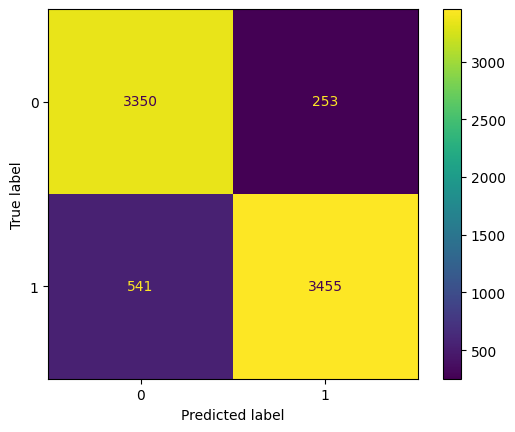

In [19]:
import matplotlib.pyplot as plt
from sklearn import metrics

actual = y_train
predicted = model.predict(X_train)

cm = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)

cm_display.plot()
plt.show()

In [20]:
import pickle

with open('stutter_model_decision_tree', 'wb') as f:
    pickle.dump(model, f)
f.close()